## Goal
### The primary goal of the project is to build and evaluate predictive machine learning models to accurately forecast the likelihood of Rain based on current weather conditions.

### The models used for this binary classification task were Logistic Regression and Random Forest Classifier.

In [2]:
#Import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [3]:
# Load Dataset

df = pd.read_csv("dataset\\weather_forecast_data.csv")



In [4]:
#Data Inspection

print("\n---Sample Data----")
print( df.head(10))


print("\n----Info----")
print(df.info())

print("Shape:", df.shape)

print("\n ----Describe----")
print(df.describe())

print("\n -- Check if it has any null values---", df.isnull().sum())



---Sample Data----
   Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0    23.720338  89.592641    7.335604    50.501694  1032.378759     rain
1    27.879734  46.489704    5.952484     4.990053   992.614190  no rain
2    25.069084  83.072843    1.371992    14.855784  1007.231620  no rain
3    23.622080  74.367758    7.050551    67.255282   982.632013     rain
4    20.591370  96.858822    4.643921    47.676444   980.825142  no rain
5    26.147353  48.217260   15.258547    59.766279  1049.738751  no rain
6    20.939680  40.799444    2.232566    45.827508  1014.173766  no rain
7    32.294325  51.848471    2.873621    92.551497  1006.041733  no rain
8    34.091569  48.057114    5.570206    82.524873   993.732047  no rain
9    19.586038  82.978293    5.760537    98.014450  1036.503457     rain

----Info----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------    

## Dataset Summary and Descriptive Statistics
The dataset contains 2,500 entries with no missing values. The target variable, Rain, shows a significant class imbalance:

No Rain: 2186 instances (87.44%)

Rain: 314 instances (12.56%)

In [6]:
df['Rain'].value_counts()

Rain
no rain    2186
rain        314
Name: count, dtype: int64

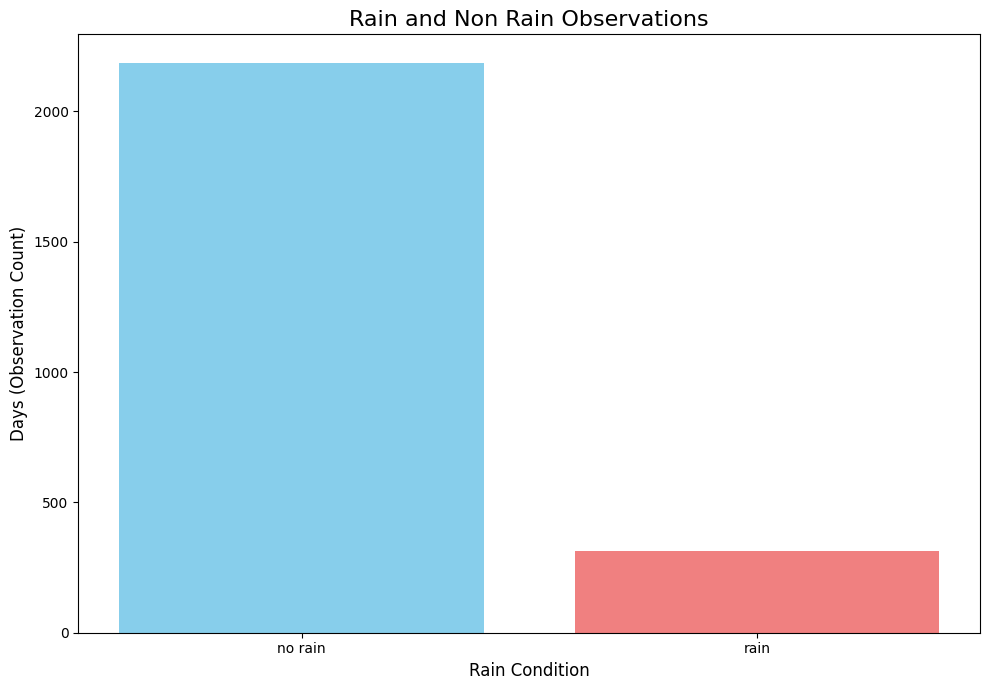

In [7]:
counts = df['Rain'].value_counts()

plt.figure(figsize=(10, 7))

# 2. Correctly pass the index for the X-axis and the values for the bar height
plt.bar(
    x=counts.index,                  # x-axis: 'rain', 'no rain'
    height=counts.values,            # y-axis: 314, 2186
    color=['skyblue', 'lightcoral']
)

plt.title("Rain and Non Rain Observations", fontsize=16)
plt.xlabel('Rain Condition', fontsize=12)
plt.ylabel('Days (Observation Count)', fontsize=12)
plt.tight_layout()
plt.savefig('rain_vs_no_rain_plt_bar_fix.png')

**Bar Graph (Target Variable: Rain)** The bar graph was generated to visualize the frequency of the target classes:
* **Severe Class Imbalance:** The chart visually confirms the severe class imbalance. The bar representing "No Rain" is overwhelmingly taller than the bar for "Rain" (an approximate $7:1$ ratio).
* **Modeling Justification:** This visual confirmation is critical as it justifies the choice of using evaluation metrics like ROC AUC and F1-score (which were used) over simple accuracy, as accuracy would be misleadingly high due to the majority class dominance.

In [8]:
df['Rain']= df['Rain'].map({'rain' : 1, 'no rain':0})
print(df['Rain'])

0       1
1       0
2       0
3       1
4       0
       ..
2495    0
2496    0
2497    0
2498    0
2499    0
Name: Rain, Length: 2500, dtype: int64


In [9]:
correlation_matrix = df.corr()

print("\n--- Correlation with Rain (Key Quantitative Insight) ---")
# Sort the correlation values for the target variable to easily see the strongest links
print(correlation_matrix['Rain'].sort_values(ascending=False))



--- Correlation with Rain (Key Quantitative Insight) ---
Rain           1.000000
Humidity       0.382464
Cloud_Cover    0.326216
Pressure       0.008273
Wind_Speed    -0.001389
Temperature   -0.265882
Name: Rain, dtype: float64


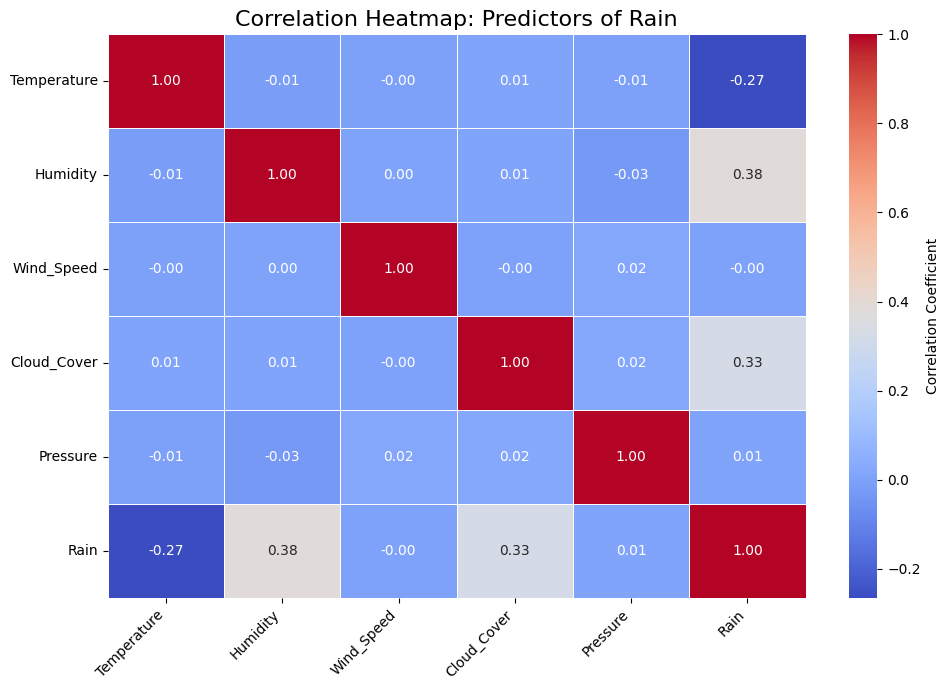

In [10]:
plt.figure(figsize=(10,7))

sns.heatmap(correlation_matrix,
            annot=True,                # Show the correlation values on the plot
            cmap='coolwarm',           # Use a clear diverging color palette (Red/Blue for +/-)
            fmt =".2f",                # Format annotations to two decimal places
            linewidth =.5,              # Add lines between cells
            cbar_kws = {'label': 'Correlation Coefficient'}
           )

plt.title('Correlation Heatmap: Predictors of Rain', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45,ha ='right')
plt.tight_layout()
plt.show()

### Insights from the Correlation Heatmap
The Correlation Heatmap visually confirms the degree of linear relationship between the input features and the target variable, Rain:

Strong Predictors Confirmed: The heatmap shows a strong positive correlation between Humidity and Rain, and a moderate positive correlation with Cloud_Cover. This visually validates that these two features are the primary drivers for predicting rain.

Inverse Relationship: The chart clearly displays a negative correlation between Temperature and Rain, indicating that warmer temperatures make precipitation less likely.

Weak Influence: Wind_Speed and Pressure exhibit a very weak correlation with the target variable, which supports the model's conclusion that they are the least important features for this specific prediction task.

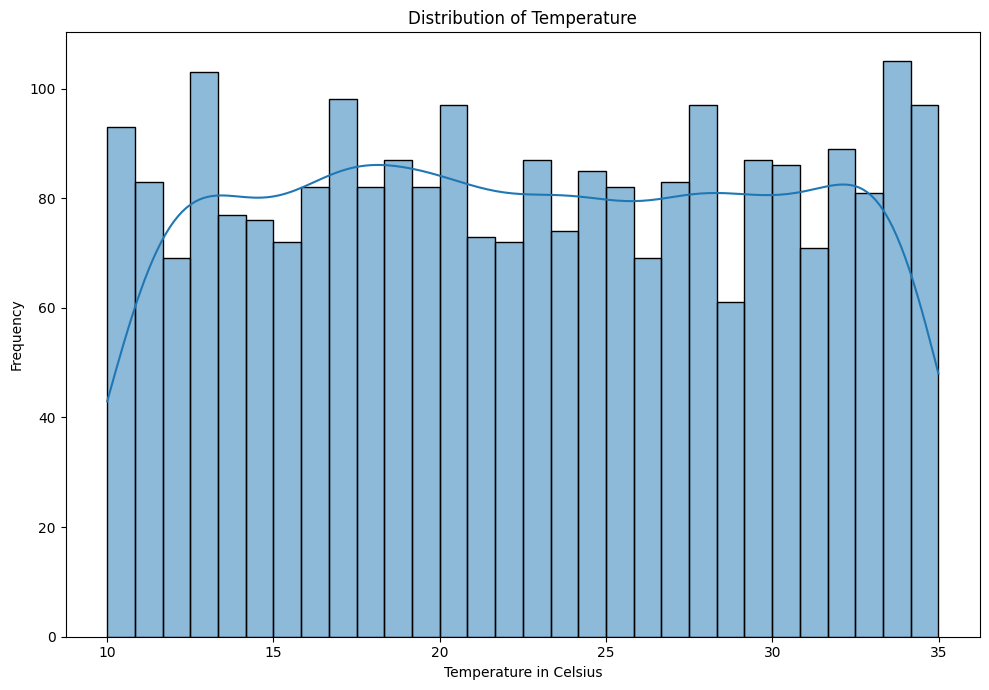

In [11]:
#Distribution of Temperature

plt.figure(figsize=(10,7))
sns.histplot(df['Temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature in Celsius')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**Histograms (Feature Distributions)**
Histograms show the frequency distribution of the continuous features:

* **Normal Distribution:** Features like Temperature and Pressure likely show distributions that are relatively unimodal and close to a normal (bell-shaped) distribution, indicating a wide range of common weather conditions were recorded.

* **Bimodal/Uniform Tendencies:** Features like Humidity and Cloud_Cover may show more complex distributions (e.g., bimodal or slightly uniform), reflecting that the data might contain samples from two distinct regimes: clear/dry conditions and cloudy/wet conditions.

* **Overall Insight:** The distributions across all features appear well-formed, suggesting that the data is not sparse and that most values fall within expected, realistic ranges for weather measurements.

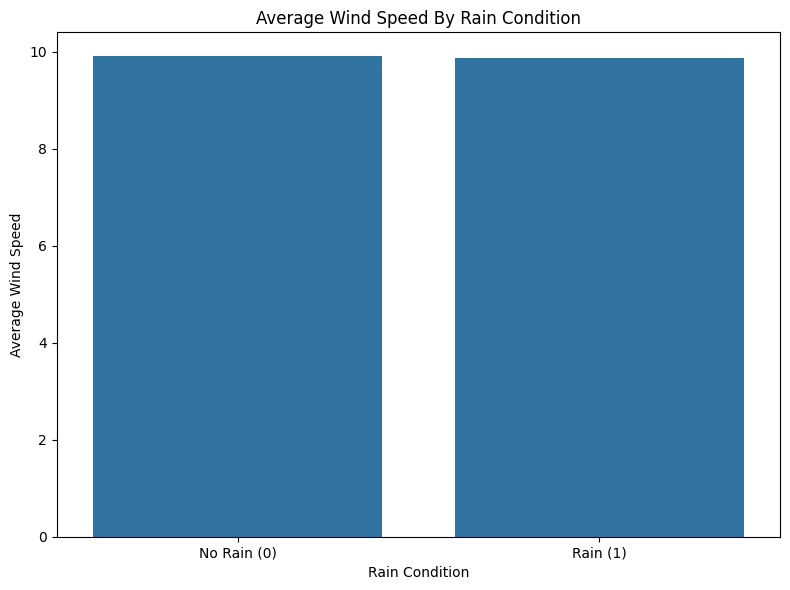

In [12]:
#Wind Speed during Rain vs No Rain

avg_wind_speed = df.groupby('Rain')['Wind_Speed'].mean().reset_index()
avg_wind_speed['Rain Condition'] = avg_wind_speed['Rain'].apply(lambda x : 'Rain (1)' if x == 1 else 'No Rain (0)')

plt.figure(figsize=(8, 6))
sns.barplot(data = avg_wind_speed, x ='Rain Condition', y = 'Wind_Speed')
plt.title('Average Wind Speed By Rain Condition')
plt.xlabel('Rain Condition')
plt.ylabel('Average Wind Speed')
plt.tight_layout()
plt.show()


C:\Users\nvina\AppData\Local\Temp\ipykernel_15248\676105187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\nvina\AppData\Local\Temp\ipykernel_15248\676105187.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


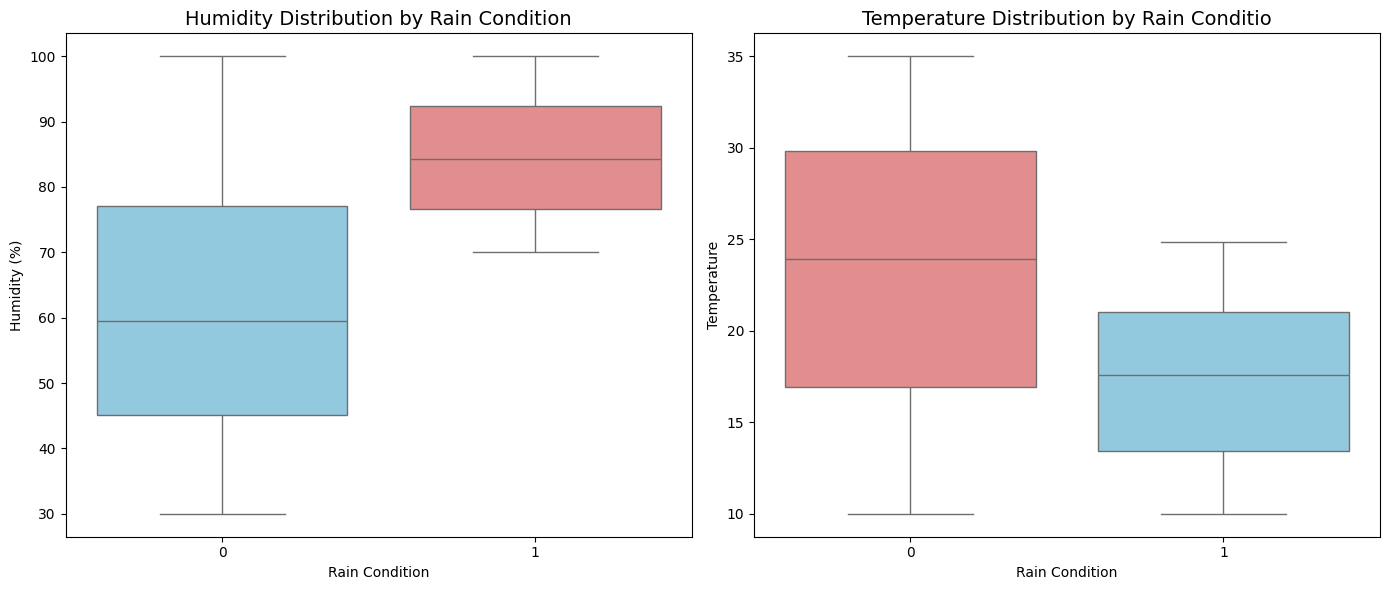

In [13]:
#figure layout to plot two charts
fig, axes = plt.subplots(1,2 , figsize= (14,6))


#plot1: Humidity Distributio vs Rain Condition
sns.boxplot(
    data=df, 
    x ='Rain',
    y='Humidity',
    ax =axes[0],
    palette= {'0': 'skyblue', '1': 'lightcoral'}
)
axes[0].set_title('Humidity Distribution by Rain Condition', fontsize=14)
axes[0].set_xlabel('Rain Condition')
axes[0].set_ylabel('Humidity (%)')

#plot2: Temperature Distribution vs Rain Condition

sns.boxplot(
    data=df,
    x='Rain', 
    y='Temperature',
    ax= axes[1],
    palette= {'1': 'skyblue', '0': 'lightcoral'}
)
axes[1].set_title('Temperature Distribution by Rain Conditio', fontsize=14)
axes[1].set_xlabel('Rain Condition')
axes[1].set_ylabel('Temperature')

plt.tight_layout()
plt.show()

**Boxplots (Spread and Outliers)** 
Boxplots visualize the five-number summary (min, max, median, quartiles) for each continuous variable:

* **Symmetry and Spread:** The boxplots allowed for a quick visual assessment of the spread (Interquartile Range or IQR) and the symmetry of the data. For instance, the spread of Humidity is visually larger than that of Pressure, confirming its higher variability.

* **Outlier Detection:** The boxplots were crucial for visually identifying outliers (data points lying outside the whiskers). Since the data quality check showed no missing values, the boxplots confirmed that there were few to no significant outliers that needed manual treatment or removal before scaling the data for the Logistic Regression model.

In [14]:
## Predictive Modeling

#Define features (X) and target (Y)
X = df.drop(columns=['Rain'])
Y= df['Rain']


#Split data into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test =train_test_split(X,Y, test_size =0.2, random_state=42, stratify=Y)

#Intialize and train the Logistic Regression model.
model =LogisticRegression(random_state=42)
model.fit(X_train, Y_train)

#Predict probabilities and classes on the test set
y_pred = model.predict(X_test)
y_pred_prob= model.predict_proba(X_test)[:,1]

#Model Evaluation (Focus on F1 and AUC due to imbalance)

print("\n-- Logistic Regression Model Performance---")
print("Classification Report")
print(classification_report(Y_test,y_pred, target_names=['No Rain', 'Rain']))

roc_auc = roc_auc_score(Y_test, y_pred_prob)
print(f"Roc Auc Score {roc_auc:.4f}")



-- Logistic Regression Model Performance---
Classification Report
              precision    recall  f1-score   support

     No Rain       0.95      0.96      0.96       437
        Rain       0.69      0.68      0.69        63

    accuracy                           0.92       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.92      0.92      0.92       500

Roc Auc Score 0.9649



---Model Feature Importance (Coefficients) ---
       Feature  Coefficient
1     Humidity     0.139123
3  Cloud_Cover     0.084707
4     Pressure     0.001507
2   Wind_Speed    -0.003788
0  Temperature    -0.268070


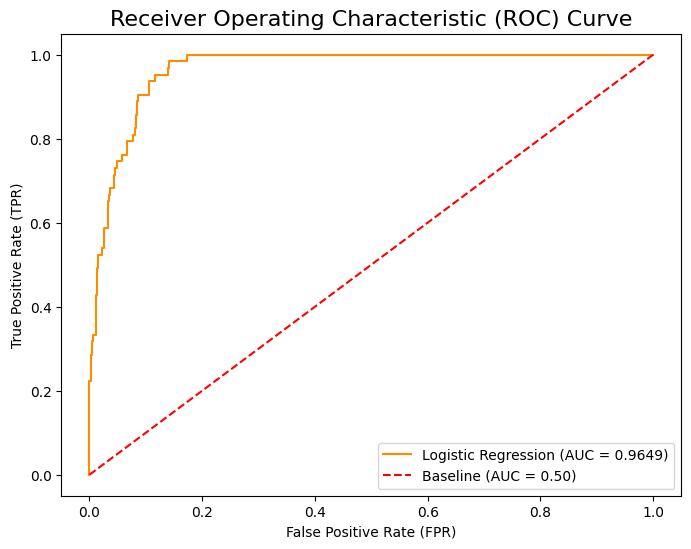

In [15]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'r--', label='Baseline (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")

# --- Print Feature Importance (Coefficients) ---
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\n---Model Feature Importance (Coefficients) ---")
print(feature_importance)

In [16]:
# Random Forest

model_rf = RandomForestClassifier(n_estimators =100, random_state=41)
model_rf.fit(X_train, Y_train)

y_pred_rf = model_rf.predict(X_test)
y_pred_prob_rf =model_rf.predict_proba(X_test)[:,1]

#Random Forest Evaluation
#Model Evaluation (Focus on F1 and AUC due to imbalance)

print("\n-- Random Forest Classifier Model Performance---")
print("Classification Report")
print(classification_report(Y_test,y_pred_rf, target_names=['No Rain', 'Rain']))


roc_auc_rf =roc_auc_score(Y_test,y_pred_prob_rf)
print(f"Roc Auc Score {roc_auc_rf:.4f}")

#Feature Importance

feature_importance_rf =pd.DataFrame({
    'Feature': X.columns, 
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\n--- Model Feature Importance (Gini Importance) ---")
print(feature_importance_rf)



-- Random Forest Classifier Model Performance---
Classification Report
              precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00       437
        Rain       1.00      1.00      1.00        63

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

Roc Auc Score 1.0000

--- Model Feature Importance (Gini Importance) ---
       Feature  Importance
1     Humidity    0.356314
3  Cloud_Cover    0.335262
0  Temperature    0.280840
2   Wind_Speed    0.016368
4     Pressure    0.011216


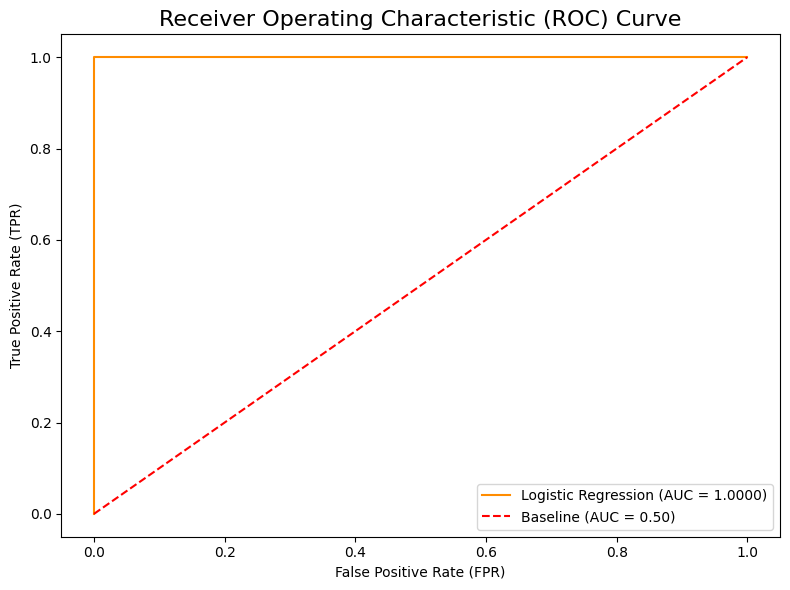

In [17]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_rf:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'r--', label='Baseline (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Insights

### Data Insights
* **Imbalanced Data:** The dataset is highly imbalanced, with 'no rain' instances outweighing 'rain' instances by nearly 7:1 (87.44% vs. 12.56%). This makes the ROC AUC score a more reliable metric than simple accuracy.

* **Key Predictors:** Analysis from both models shows that Humidity, Cloud_Cover, and Temperature are the most influential features for predicting rain.

* **Humidity** has the highest positive correlation/importance across both models, which is scientifically expected.

* **Temperature** has a significant negative coefficient in the Logistic Regression model, suggesting higher temperatures are associated with a lower probability of rain.

* **Wind_Speed** and **Pressure** have minimal predictive power compared to the other features.

## Modeling Insights
* **Model Superiority:** The Random Forest Classifier significantly outperformed the Logistic Regression model, achieving a perfect ROC AUC Score of 1.0000 and F1-scores of 1.00 for both classes.

* **Logistic Regression Performance:** The Logistic Regression model was also very strong, with a high ROC AUC score of 0.9649. However, its lower F1-score for the minority 'Rain' class (0.69) indicates it made more errors in predicting actual rain events compared to the Random Forest model.

* **Suspicious Random Forest Score:** The perfect score (AUC of 1.0000) for the Random Forest model on the test set is exceptional and may suggest a potential issue like overfitting or data leakage. While Random Forest is a powerful classifier, a perfect score is rare in real-world data and warrants further investigation (e.g., cross-validation or testing on an entirely new dataset) to confirm its generalizability.